In [1]:
import getfem as gf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [10]:

# --------------------------------------- Project Description ---------------------------------------
## This project simulates stress redistribution in the rock mass surrounding an underground mining excavation. 
## I idealize the problem as a two-dimensional cross-section of the rock under plane–strain conditions, representing 
## a slice perpendicular to the mine drift or room. The domain consists of an elastic rock mass that contains one or more 
## excavated openings and, in some scenarios, intact rock pillars left between excavations.


## The animation will show the development of the MV stress field through time as rock is removed from the mine area. A stess threshold
## of 100 MPA will be use to determine where failure will occur, denoted by red mesh coloring. Variations in support pillar placement
## will offer futher understanding of stabilization options. 

## The mine set-up is an approximination of coal mining (and some deep metal mining) operatons; having a planar extraction type with
## constructued support pillars. Additional work can be done to simulate mining through a fault zone, a common coal mining failure
## scenario. 


# Literature:
## https://pubs.usgs.gov/pp/0965/report.pdf
## https://www.omicsonline.org/open-access-pdfs/full-threedimensional-finite-element-analysis-of-the-stress-redistribution-in-mine-structural-pillar-2168-9806.1000119.pdf




In [4]:
#Set-up Mesh Params
Lx, Ly = 25.0, 40.0     # domain size in meters
nx, ny = 100, 160       # number of elements in x and y

m = gf.Mesh(
    'cartesian',
    np.linspace(0, Lx, nx + 1),
    np.linspace(0, Ly, ny + 1)
)

# ---------------------------------------------------------
#  DISPLACEMENT FIELD (2D, Q1 elements on quads)
# ---------------------------------------------------------
mf_u = gf.MeshFem(m, 2)                       # 2 components (ux, uy)
mf_u.set_fem(gf.Fem('FEM_QK(2,1)'))          # Q1 on quads

# Integration method for volume
mim = gf.MeshIm(m, gf.Integ('IM_GAUSS_PARALLELEPIPED(2,4)'))

# Model
md = gf.Model('real')
md.add_fem_variable('u', mf_u)

# ---------------------------------------------------------
#  MATERIAL PARAMETERS (uniform for now)
# ---------------------------------------------------------
E   = 35e9     # Young's modulus (Pa)†
nu  = 0.25     # Poisson's ratio
rho = 2700.0   # Density (kg/m^3)
g   = 9.81     # Gravity (m/s^2)

lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu  = E / (2.0 * (1.0 + nu))

md.add_initialized_data('lambda', [lam])
md.add_initialized_data('mu', [mu])
md.add_isotropic_linearized_elasticity_brick(mim, 'u', 'lambda', 'mu')

# Body force: gravity
md.add_initialized_data('gravity', [0.0, -rho * g])
md.add_source_term_brick(mim, 'u', 'gravity')

# ---------------------------------------------------------
#  BOUNDARY CONDITIONS
#  - Bottom boundary fully fixed (ux = uy = 0)
# ---------------------------------------------------------
BOTTOM_REGION_ID = 1

fb = m.outer_faces()
normals = m.normal_of_faces(fb)  # normals[0,:] = nx, normals[1,:] = ny

# bottom boundary: outward normal roughly pointing downward (ny < -0.99)
bottom_faces = fb[:, np.where(normals[1, :] < -0.99)[0]]
m.set_region(BOTTOM_REGION_ID, bottom_faces)

penalty = 1e10  # large penalty to approximate Dirichlet
md.add_Dirichlet_condition_with_penalization(mim, 'u', penalty, BOTTOM_REGION_ID)

# ---------------------------------------------------------
#  SOLVE STATIC PROBLEM (gravity + fixed bottom)
# ---------------------------------------------------------
md.solve()
U = md.variable('u')  # displacement DOFs as a flat array


Trace 2 in getfem_models.cc, line 6051: Linearized isotropic elasticity: generic matrix assembly
Trace 2 in getfem_models.cc, line 3308: Generic source term assembly
Trace 2 in getfem_models.cc, line 3319: Source term: generic source term assembly
Trace 2 in getfem_models.cc, line 4399: Mass term assembly for Dirichlet condition


In [5]:
# ===================== BLOCK 1: PHYSICAL PARAMETERS =====================

# Rock (intact)
E_rock = 35e9       # Pa
nu_rock = 0.25

# Void / very soft material inside room
E_soft = 1e7        # Pa
nu_soft = 0.25

# Support band material (mesh + bolts + shotcrete-ish)
# Only used in supported room setup
E_sup = 5e9         # Pa
nu_sup = 0.25

def lame_from_Enu(E, nu):
    lam = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
    mu  = E / (2.0 * (1.0 + nu))
    return lam, mu

lam_r,   mu_r   = lame_from_Enu(E_rock, nu_rock)
lam_s,   mu_s   = lame_from_Enu(E_soft, nu_soft)
lam_sup, mu_sup = lame_from_Enu(E_sup,  nu_sup)

# Far-field stresses (tune these to get a stable frame 0 in core rock)
sigma_y = 5e6   # Pa, vertical compression (overburden)
sigma_x = 3e6   # Pa, horizontal compression

# Failure threshold in rock (absolute Von Mises)
sigma_crit_MPa = 100.0
sigma_crit     = sigma_crit_MPa * 1e6

# Region IDs (shared by both room setups)
ROCK_REGION    = 10
SOFT_REGION    = 11
WEAK_REGION    = 12
SUPPORT_REGION = 13  # only used in supported room

# A small band thickness used to define a "near-room" interface zone
dx_cell = Lx / nx
dy_cell = Ly / ny
boundary_band = 1.0 * min(dx_cell, dy_cell)  # ~1 cell thick


In [11]:
# ===================== BLOCK 2: ROOM SETUP (TWO OPTIONS) =====================
# Global flags that control behavior of helper functions
ROOM_VARIANT     = None   # "rect_unsupported" or "supported_beveled"
ROOM_HAS_SUPPORT = False
ROOM_BEVELED     = False

# Geometry globals (filled by setup_... functions)
chamber_rect          = None
corridor_rect         = None
bevel                 = 0.0
pillar_w = pillar_h   = None
corner_rock_pillars   = []
far_pillar            = None
safety_pillar         = None
USE_SAFETY_PILLAR     = True
support_thickness     = 0.0  # used only in supported room

x_nodes=[]
y_nodes = []



def in_rect_xy(x, y, rect):
    return ((rect['x0'] <= x) & (x <= rect['x1']) & (rect['y0'] <= y) & (y <= rect['y1']))


# ---------- ROOM SETUP 1: Rectangular, unsupported walls ----------

def setup_room_rect_unsupported():
    global ROOM_VARIANT, ROOM_HAS_SUPPORT, ROOM_BEVELED
    global chamber_rect, corridor_rect, bevel
    global pillar_w, pillar_h, corner_rock_pillars, far_pillar
    global safety_pillar, USE_SAFETY_PILLAR, support_thickness

    ROOM_VARIANT     = "rect_unsupported"
    ROOM_HAS_SUPPORT = False
    ROOM_BEVELED     = False
    support_thickness = 0.0
    bevel = 0.0

    # Chamber rectangle
    chamber_rect = {
        'x0': 0.30 * Lx,
        'x1': 0.90 * Lx,
        'y0': 0.35 * Ly,
        'y1': 0.85 * Ly
    }

    chamber_width  = chamber_rect['x1'] - chamber_rect['x0']
    chamber_height = chamber_rect['y1'] - chamber_rect['y0']
    y_center_chamber = 0.5 * (chamber_rect['y0'] + chamber_rect['y1'])

    # Narrow corridor (entrance) from left boundary
    corridor_height = 0.4 * chamber_height
    corridor_rect = {
        'x0': 0.0,
        'x1': chamber_rect['x0'],
        'y0': y_center_chamber - 0.5 * corridor_height,
        'y1': y_center_chamber + 0.5 * corridor_height
    }

    globals()['corridor_rect'] = corridor_rect  # assign to global

    # Pillar geometry
    pillar_w = 2.0
    pillar_h = 2.0

    dx = 0.15 * chamber_width
    dy = 0.15 * chamber_height

    cx_tl = chamber_rect['x0'] + dx
    cx_tr = chamber_rect['x1'] - dx
    cx_bl = chamber_rect['x0'] + dx
    cx_br = chamber_rect['x1'] - dx

    cy_t = chamber_rect['y1'] - dy
    cy_b = chamber_rect['y0'] + dy

    pillar_TL = {
        'x0': cx_tl - pillar_w/2,
        'x1': cx_tl + pillar_w/2,
        'y0': cy_t  - pillar_h/2,
        'y1': cy_t  + pillar_h/2
    }
    pillar_TR = {
        'x0': cx_tr - pillar_w/2,
        'x1': cx_tr + pillar_w/2,
        'y0': cy_t  - pillar_h/2,
        'y1': cy_t  + pillar_h/2
    }
    pillar_BL = {
        'x0': cx_bl - pillar_w/2,
        'x1': cx_bl + pillar_w/2,
        'y0': cy_b  - pillar_h/2,
        'y1': cy_b  + pillar_h/2
    }
    pillar_BR = {
        'x0': cx_br - pillar_w/2,
        'x1': cx_br + pillar_w/2,
        'y0': cy_b  - pillar_h/2,
        'y1': cy_b  + pillar_h/2
    }

    globals()['pillar_w'] = pillar_w
    globals()['pillar_h'] = pillar_h

    # Far pillar to weaken = top-right
    globals()['far_pillar'] = pillar_TR

    # Other three = always rock
    globals()['corner_rock_pillars'] = [pillar_TL, pillar_BL, pillar_BR]

    # Safety pillar
    safety_center_x = chamber_rect['x0'] + pillar_w/2
    safety_center_y = y_center_chamber + 2.0
    safety_pillar = {
        'x0': safety_center_x - pillar_w/2,
        'x1': safety_center_x + pillar_w/2,
        'y0': safety_center_y - pillar_h/2,
        'y1': safety_center_y + pillar_h/2
    }
    globals()['safety_pillar'] = safety_pillar
    globals()['USE_SAFETY_PILLAR'] = True

    print("Room variant: rectangular, unsupported walls.")






# ---------- ROOM SETUP 2: Supported, beveled chamber ----------

def setup_room_supported_beveled():
    global ROOM_VARIANT, ROOM_HAS_SUPPORT, ROOM_BEVELED
    global chamber_rect, corridor_rect, bevel
    global pillar_w, pillar_h, corner_rock_pillars, far_pillar
    global safety_pillar, USE_SAFETY_PILLAR, support_thickness

    ROOM_VARIANT     = "supported_beveled"
    ROOM_HAS_SUPPORT = True
    ROOM_BEVELED     = True

    support_thickness = 1.5  # meters (band thickness along room walls)

    # Chamber rectangle (outer bounding box of beveled chamber)
    chamber_rect = {
        'x0': 0.35 * Lx,
        'x1': 0.90 * Lx,
        'y0': 0.35 * Ly,
        'y1': 0.85 * Ly
    }

    chamber_width  = chamber_rect['x1'] - chamber_rect['x0']
    chamber_height = chamber_rect['y1'] - chamber_rect['y0']
    y_center_chamber = 0.5 * (chamber_rect['y0'] + chamber_rect['y1'])

    # Bevel size (chamfer)
    bevel = 0.25 * min(chamber_width, chamber_height)

    # Corridor
    corridor_height = 0.4 * chamber_height
    corridor_rect = {
        'x0': 0.0,
        'x1': chamber_rect['x0'],
        'y0': y_center_chamber - 0.5 * corridor_height,
        'y1': y_center_chamber + 0.5 * corridor_height
    }

    globals()['corridor_rect'] = corridor_rect
    globals()['bevel']         = bevel

    # Pillars similar to rectangular case
    pillar_w = 2.0
    pillar_h = 2.0

    dx = 0.15 * chamber_width
    dy = 0.15 * chamber_height

    cx_tl = chamber_rect['x0'] + dx
    cx_tr = chamber_rect['x1'] - dx
    cx_bl = chamber_rect['x0'] + dx
    cx_br = chamber_rect['x1'] - dx

    cy_t = chamber_rect['y1'] - dy
    cy_b = chamber_rect['y0'] + dy

    pillar_TL = {
        'x0': cx_tl - pillar_w/2,
        'x1': cx_tl + pillar_w/2,
        'y0': cy_t  - pillar_h/2,
        'y1': cy_t  + pillar_h/2
    }
    pillar_TR = {
        'x0': cx_tr - pillar_w/2,
        'x1': cx_tr + pillar_w/2,
        'y0': cy_t  - pillar_h/2,
        'y1': cy_t  + pillar_h/2
    }
    pillar_BL = {
        'x0': cx_bl - pillar_w/2,
        'x1': cx_bl + pillar_w/2,
        'y0': cy_b  - pillar_h/2,
        'y1': cy_b  + pillar_h/2
    }
    pillar_BR = {
        'x0': cx_br - pillar_w/2,
        'x1': cx_br + pillar_w/2,
        'y0': cy_b  - pillar_h/2,
        'y1': cy_b  + pillar_h/2
    }

    globals()['pillar_w'] = pillar_w
    globals()['pillar_h'] = pillar_h

    globals()['far_pillar'] = pillar_TR
    globals()['corner_rock_pillars'] = [pillar_TL, pillar_BL, pillar_BR]

    safety_center_x = chamber_rect['x0'] + pillar_w/2
    safety_center_y = y_center_chamber + 2.0
    safety_pillar = {
        'x0': safety_center_x - pillar_w/2,
        'x1': safety_center_x + pillar_w/2,
        'y0': safety_center_y - pillar_h/2,
        'y1': safety_center_y + pillar_h/2
    }
    globals()['safety_pillar'] = safety_pillar
    globals()['USE_SAFETY_PILLAR'] = True

    print("Room variant: supported, beveled chamber.")

    


# ---------- Helper geometry for classification & masks ----------

def in_beveled_chamber_scalar(x, y):
    if not ((chamber_rect['x0'] <= x <= chamber_rect['x1']) and
            (chamber_rect['y0'] <= y <= chamber_rect['y1'])):
        return False

    x0, x1 = chamber_rect['x0'], chamber_rect['x1']
    y0, y1 = chamber_rect['y0'], chamber_rect['y1']

    u_tl = x - x0
    v_tl = y1 - y

    u_tr = x1 - x
    v_tr = y1 - y

    u_br = x1 - x
    v_br = y - y0

    u_bl = x - x0
    v_bl = y - y0

    return (
        (u_tl + v_tl >= bevel) and
        (u_tr + v_tr >= bevel) and
        (u_br + v_br >= bevel) and
        (u_bl + v_bl >= bevel)
    )


def classify_regions_for_factor(factor: float):
    """
    Assign convex regions based on current ROOM_VARIANT.

    - In both variants:
        * Outside room  -> ROCK_REGION
        * Far pillar    -> ROCK / WEAK / SOFT depending on 'factor'
        * Other pillars + safety -> ROCK_REGION
        * Room minus pillars:
            - Rect: SOFT (void)
            - Supported: SUPPORT band near walls, SOFT in the interior
    """
    rock_ids    = []
    soft_ids    = []
    weak_ids    = []
    support_ids = []

    for j in range(ny):
        for i in range(nx):
            cv = j*nx + i
            x_c = 0.5 * (x_nodes[i]   + x_nodes[i+1])
            y_c = 0.5 * (y_nodes[j]   + y_nodes[j+1])

            # Room membership (scalar)
            if ROOM_BEVELED:
                in_chamber = in_beveled_chamber_scalar(x_c, y_c)
            else:
                in_chamber = in_rect_xy(x_c, y_c, chamber_rect)

            in_corridor = in_rect_xy(x_c, y_c, corridor_rect)
            in_room     = in_chamber or in_corridor

            # Pillars
            def in_pillar(rect):
                return (rect['x0'] <= x_c <= rect['x1']) and (rect['y0'] <= y_c <= rect['y1'])

            in_far    = in_pillar(far_pillar)
            in_corner = any(in_pillar(p) for p in corner_rock_pillars)
            in_safety = USE_SAFETY_PILLAR and in_pillar(safety_pillar)

            # Support band (only used if ROOM_HAS_SUPPORT)
            near_wall = False
            if ROOM_HAS_SUPPORT and in_room:
                # distances to chamber
                dist_left_c   = x_c - chamber_rect['x0']
                dist_right_c  = chamber_rect['x1'] - x_c
                dist_bottom_c = y_c - chamber_rect['y0']
                dist_top_c    = chamber_rect['y1'] - y_c
                min_dist_c    = min(dist_left_c, dist_right_c, dist_bottom_c, dist_top_c)

                # distances to corridor
                dist_left_k   = x_c - corridor_rect['x0']
                dist_right_k  = corridor_rect['x1'] - x_c
                dist_bottom_k = y_c - corridor_rect['y0']
                dist_top_k    = corridor_rect['y1'] - y_c
                min_dist_k    = min(dist_left_k, dist_right_k, dist_bottom_k, dist_top_k)

                near_chamber_wall  = in_chamber and (min_dist_c <= support_thickness)
                near_corridor_wall = in_corridor and (min_dist_k <= support_thickness)
                near_wall          = near_chamber_wall or near_corridor_wall

            if in_room:
                # Pillars override void/support
                if in_corner or in_safety:
                    rock_ids.append(cv)
                elif in_far:
                    if factor >= 1.0 - 1e-8:
                        rock_ids.append(cv)
                    elif factor <= 1e-8:
                        soft_ids.append(cv)
                    else:
                        weak_ids.append(cv)
                else:
                    # In room but not in pillars
                    if ROOM_HAS_SUPPORT and near_wall:
                        support_ids.append(cv)
                    else:
                        soft_ids.append(cv)
            else:
                rock_ids.append(cv)

    rock_arr    = np.array(rock_ids,    dtype=int).reshape(1, -1) if rock_ids    else np.zeros((1, 0), dtype=int)
    soft_arr    = np.array(soft_ids,    dtype=int).reshape(1, -1) if soft_ids    else np.zeros((1, 0), dtype=int)
    weak_arr    = np.array(weak_ids,    dtype=int).reshape(1, -1) if weak_ids    else np.zeros((1, 0), dtype=int)
    support_arr = np.array(support_ids, dtype=int).reshape(1, -1) if support_ids else np.zeros((1, 0), dtype=int)

    m.set_region(ROCK_REGION,    rock_arr)
    m.set_region(SOFT_REGION,    soft_arr)
    m.set_region(WEAK_REGION,    weak_arr)
    m.set_region(SUPPORT_REGION, support_arr)


def rock_mask_nodes(x, y):
    """
    Node-level mask for 'solid' material (rock-like zones).
    Approximate: outside room OR pillars OR (if present) support band.
    """
    # Room rectangles (we ignore bevel for mask simplicity)
    in_chamber_rect = in_rect_xy(x, y, chamber_rect)
    in_corridor     = in_rect_xy(x, y, corridor_rect)
    in_room_pts     = in_chamber_rect | in_corridor

    # Pillars
    def in_pillar_pts(rect):
        return ((rect['x0'] <= x) & (x <= rect['x1']) &
                (rect['y0'] <= y) & (y <= rect['y1']))

    in_far_pts = in_pillar_pts(far_pillar)
    in_corner_pts = np.zeros_like(x, dtype=bool)
    for p in corner_rock_pillars:
        in_corner_pts |= in_pillar_pts(p)
    in_safety_pts = in_pillar_pts(safety_pillar) if USE_SAFETY_PILLAR else np.zeros_like(x, dtype=bool)

    # Support band (only if ROOM_HAS_SUPPORT)
    if ROOM_HAS_SUPPORT:
        dist_left_c   = x - chamber_rect['x0']
        dist_right_c  = chamber_rect['x1'] - x
        dist_bottom_c = y - chamber_rect['y0']
        dist_top_c    = chamber_rect['y1'] - y
        min_dist_c    = np.minimum.reduce([dist_left_c, dist_right_c, dist_bottom_c, dist_top_c])

        dist_left_k   = x - corridor_rect['x0']
        dist_right_k  = corridor_rect['x1'] - x
        dist_bottom_k = y - corridor_rect['y0']
        dist_top_k    = corridor_rect['y1'] - y
        min_dist_k    = np.minimum.reduce([dist_left_k, dist_right_k, dist_bottom_k, dist_top_k])

        near_chamber_wall  = in_chamber_rect & (min_dist_c <= support_thickness)
        near_corridor_wall = in_corridor     & (min_dist_k <= support_thickness)
        in_support_pts     = near_chamber_wall | near_corridor_wall
    else:
        in_support_pts = np.zeros_like(x, dtype=bool)

    # Solid = outside room OR pillars OR support
    in_rock_pts = (~in_room_pts) | in_corner_pts | in_far_pts | in_safety_pts | in_support_pts
    return in_rock_pts


def core_rock_mask_nodes(x, y):
    """
    Core rock = rock-like nodes that are NOT in the immediate room boundary band.
    This avoids the singular stress ring when computing failure statistics.
    """
    in_rock = rock_mask_nodes(x, y)

    near_chamber_band = (
        (chamber_rect['x0'] - boundary_band <= x) & (x <= chamber_rect['x1'] + boundary_band) &
        (chamber_rect['y0'] - boundary_band <= y) & (y <= chamber_rect['y1'] + boundary_band)
    )
    near_corridor_band = (
        (corridor_rect['x0'] - boundary_band <= x) & (x <= corridor_rect['x1'] + boundary_band) &
        (corridor_rect['y0'] - boundary_band <= y) & (y <= corridor_rect['y1'] + boundary_band)
    )
    near_interface = near_chamber_band | near_corridor_band

    return in_rock & (~near_interface)


In [7]:
# ===================== BLOCK: ROOM LAYOUT PREVIEW =====================
def plot_room_setup():
    if ROOM_VARIANT is None:
        raise RuntimeError("Call a room setup first")

    fig, ax = plt.subplots(figsize=(7, 4))

    # --------- Chamber outline ---------
    if ROOM_BEVELED and bevel is not None and bevel > 0.0:
        # Beveled (chamfered) chamber as an 8-sided polygon
        x0, x1 = chamber_rect['x0'], chamber_rect['x1']
        y0, y1 = chamber_rect['y0'], chamber_rect['y1']
        b = bevel

        verts = [
            (x0 + b, y1),      # top edge, a bit away from top-left
            (x1 - b, y1),      # top edge, a bit away from top-right
            (x1,     y1 - b),  # chamfer near top-right
            (x1,     y0 + b),  # right edge
            (x1 - b, y0),      # chamfer near bottom-right
            (x0 + b, y0),      # bottom edge
            (x0,     y0 + b),  # chamfer near bottom-left
            (x0,     y1 - b),  # left edge
        ]
        cham_poly = patches.Polygon(
            verts,
            closed=True,
            fill=False,
            linewidth=1.8,
            edgecolor='white',
            linestyle='--'
        )
        ax.add_patch(cham_poly)
    else:
        # Simple rectangular chamber
        chamber_patch = patches.Rectangle(
            (chamber_rect['x0'], chamber_rect['y0']),
            chamber_rect['x1'] - chamber_rect['x0'],
            chamber_rect['y1'] - chamber_rect['y0'],
            linewidth=1.8, edgecolor='white', facecolor='none', linestyle='--'
        )
        ax.add_patch(chamber_patch)

    # --------- Corridor / entrance ---------
    corridor_patch = patches.Rectangle(
        (corridor_rect['x0'], corridor_rect['y0']),
        corridor_rect['x1'] - corridor_rect['x0'],
        corridor_rect['y1'] - corridor_rect['y0'],
        linewidth=1.4, edgecolor='white', facecolor='none', linestyle=':'
    )
    ax.add_patch(corridor_patch)

    # Label entrance
    y_center_chamber = 0.5 * (chamber_rect['y0'] + chamber_rect['y1'])
    ax.text(corridor_rect['x0'] + 0.5,
            y_center_chamber,
            "Entrance",
            ha='left', va='center', fontsize=8, color='white')

    # --------- Support bands (only for supported room) ---------
    if ROOM_HAS_SUPPORT and support_thickness > 0.0:
        # Simple wall bands around chamber (schematic, not exact bevel)
        x0, x1 = chamber_rect['x0'], chamber_rect['x1']
        y0, y1 = chamber_rect['y0'], chamber_rect['y1']
        t = support_thickness

        # Chamber bands
        bands = [
            (x0,      y0,      t,      y1 - y0),      # left
            (x1 - t,  y0,      t,      y1 - y0),      # right
            (x0,      y0,      x1-x0,  t),            # bottom
            (x0,      y1 - t,  x1-x0,  t),            # top
        ]

        # Corridor bands
        kx0, ky0 = corridor_rect['x0'], corridor_rect['y0']
        kx1, ky1 = corridor_rect['x1'], corridor_rect['y1']
        bands += [
            (kx0,     ky0,     t,      ky1 - ky0),    # corridor left
            (kx1 - t, ky0,     t,      ky1 - ky0),    # corridor right
        ]

        for (bx, by, bw, bh) in bands:
            band_rect = patches.Rectangle(
                (bx, by), bw, bh,
                linewidth=0.8,
                edgecolor='yellow',
                facecolor='yellow',
                alpha=0.25
            )
            ax.add_patch(band_rect)

        ax.text(
            x1, y1 + 0.5,
            "Support band (mesh/bolts)",
            ha='right', va='bottom', fontsize=7, color='yellow'
        )

    # --------- Pillars: corner, far, safety ---------
    # Corner pillars (always rock)
    for p in corner_rock_pillars:
        rect = patches.Rectangle(
            (p['x0'], p['y0']),
            p['x1'] - p['x0'],
            p['y1'] - p['y0'],
            linewidth=2.0, edgecolor='black', facecolor='0.8'
        )
        ax.add_patch(rect)

    # Far pillar (to be weakened) – draw in a distinct color
    if far_pillar is not None:
        fp = far_pillar
        far_rect = patches.Rectangle(
            (fp['x0'], fp['y0']),
            fp['x1'] - fp['x0'],
            fp['y1'] - fp['y0'],
            linewidth=2.0, edgecolor='red', facecolor='none'
        )
        ax.add_patch(far_rect)
        far_cx = 0.5 * (fp['x0'] + fp['x1'])
        far_cy = 0.5 * (fp['y0'] + fp['y1'])
        ax.text(far_cx, far_cy, "Far\npillar",
                ha='center', va='center', fontsize=7, color='red')

    # Safety pillar near entrance
    if USE_SAFETY_PILLAR and safety_pillar is not None:
        sp = safety_pillar
        safety_rect = patches.Rectangle(
            (sp['x0'], sp['y0']),
            sp['x1'] - sp['x0'],
            sp['y1'] - sp['y0'],
            linewidth=2.0, edgecolor='black', facecolor='0.6'
        )
        ax.add_patch(safety_rect)
        safety_cx = 0.5 * (sp['x0'] + sp['x1'])
        safety_cy = 0.5 * (sp['y0'] + sp['y1'])
        ax.text(safety_cx, safety_cy, "Safety",
                ha='center', va='center', fontsize=7, color='black')

    # --------- Axes / labels ---------
    ax.set_aspect('equal', 'box')
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")

    title_bits = []
    if ROOM_VARIANT == "rect_unsupported":
        title_bits.append("Rectangular room, unsupported walls")
    elif ROOM_VARIANT == "supported_beveled":
        title_bits.append("Beveled room with wall support")

    ax.set_title("Room layout\n" + " | ".join(title_bits), fontsize=11)
    plt.tight_layout()
    plt.show()


In [8]:
# ===================== BLOCK 3: ANIMATION / SWEEP HELPER =====================
def _build_model_for_factor(factor: float):
    md = gf.Model('real')
    md.add_fem_variable('u', mf_u)

    lam_w = lam_r * factor
    mu_w  = mu_r  * factor

    md.add_initialized_data('lambda_rock', [lam_r])
    md.add_initialized_data('mu_rock',     [mu_r])
    md.add_initialized_data('lambda_soft', [lam_s])
    md.add_initialized_data('mu_soft',     [mu_s])
    md.add_initialized_data('lambda_weak', [lam_w])
    md.add_initialized_data('mu_weak',     [mu_w])

    if ROOM_HAS_SUPPORT:
        md.add_initialized_data('lambda_support', [lam_sup])
        md.add_initialized_data('mu_support',     [mu_sup])

    md.add_isotropic_linearized_elasticity_brick(
        mim, 'u', 'lambda_rock', 'mu_rock', ROCK_REGION
    )
    md.add_isotropic_linearized_elasticity_brick(
        mim, 'u', 'lambda_soft', 'mu_soft', SOFT_REGION
    )
    md.add_isotropic_linearized_elasticity_brick(
        mim, 'u', 'lambda_weak', 'mu_weak', WEAK_REGION
    )
    if ROOM_HAS_SUPPORT:
        md.add_isotropic_linearized_elasticity_brick(
            mim, 'u', 'lambda_support', 'mu_support', SUPPORT_REGION
        )

    # Far-field tractions
    md.add_initialized_data('t_top',   [0.0, -sigma_y])
    md.add_initialized_data('t_left',  [ sigma_x, 0.0])
    md.add_initialized_data('t_right', [-sigma_x, 0.0])

    md.add_source_term_brick(mim, 'u', 't_top',   TOP)
    md.add_source_term_brick(mim, 'u', 't_left',  LEFT)
    md.add_source_term_brick(mim, 'u', 't_right', RIGHT)

    penalty = 1e10
    md.add_Dirichlet_condition_with_penalization(mim, 'u', penalty, BOTTOM)

    return md


def run_pillar_animation(factors=None, make_diff=True):
    if ROOM_VARIANT is None:
        raise RuntimeError("Call a room setup first")

    if factors is None:
        factors = np.linspace(1.0, 0.0, 11)

    # ----------------------------------------------------
    # Baseline: factor = 1.0 (all pillars intact)
    # ----------------------------------------------------
    classify_regions_for_factor(1.0)
    md0 = _build_model_for_factor(1.0)
    md0.solve()

    VM0 = md0.compute_isotropic_linearized_Von_Mises_or_Tresca(
        'u', 'lambda_rock', 'mu_rock', mf_s, 'Von_Mises'
    )
    vm0_MPa = VM0 / 1e6

    P = mf_s.basic_dof_nodes()
    x = P[0, :]
    y = P[1, :]

    in_core0 = core_rock_mask_nodes(x, y)
    rock_vm0_max = vm0_MPa[in_core0].max() if np.any(in_core0) else np.nan

    failed0 = (vm0_MPa > sigma_crit_MPa) & in_core0
    rock0_count = np.count_nonzero(in_core0)
    failure_frac0 = np.count_nonzero(failed0) / rock0_count if rock0_count > 0 else 0.0

    print(f"  Max Von Mises (all)      = {vm0_MPa.max():.2f} MPa")
    print(f"  Max Von Mises (core rock)= {rock_vm0_max:.2f} MPa")
    print(f"  Initial CORE failure fraction = {failure_frac0:.3f}")

    
    for idx, factor in enumerate(factors):
        print(f"\n=== Step {idx}, far pillar stiffness factor = {factor:.2f} ===")
        classify_regions_for_factor(factor)
        md = _build_model_for_factor(factor)
        md.solve()

        VM = md.compute_isotropic_linearized_Von_Mises_or_Tresca(
            'u', 'lambda_rock', 'mu_rock', mf_s, 'Von_Mises'
        )
        vm_MPa = VM / 1e6

        P = mf_s.basic_dof_nodes()
        x = P[0, :]
        y = P[1, :]

        in_core = core_rock_mask_nodes(x, y)
        rock_vm_max = vm_MPa[in_core].max() if np.any(in_core) else np.nan

        failed = (vm_MPa > sigma_crit_MPa) & in_core
        rock_count = np.count_nonzero(in_core)
        failure_fraction = np.count_nonzero(failed) / rock_count if rock_count > 0 else 0.0

        print(f"  Max Von Mises (all)      = {vm_MPa.max():.2f} MPa")
        print(f"  Max Von Mises (core rock)= {rock_vm_max:.2f} MPa")
        print(f"  CORE ROCK failure fraction = {failure_fraction:.3f}")

        # ---------- Absolute VM plot ----------
        fig, ax = plt.subplots(figsize=(7, 4))

        levels_vm = np.linspace(vm_MPa.min(), vm_MPa.max(), 40)
        tcf = ax.tricontourf(x, y, vm_MPa, levels=levels_vm)
        cb = plt.colorbar(tcf, ax=ax, label='Von Mises (MPa)')

        if np.any(failed):
            ax.scatter(x[failed], y[failed], s=5,
                       facecolors='none', edgecolors='red', linewidths=0.5)

        # Draw room outline (rectangular box; bevel is implied in regions)
        chamber_patch = patches.Rectangle(
            (chamber_rect['x0'], chamber_rect['y0']),
            chamber_rect['x1'] - chamber_rect['x0'],
            chamber_rect['y1'] - chamber_rect['y0'],
            linewidth=1.5, edgecolor='white', facecolor='none', linestyle='--'
        )
        ax.add_patch(chamber_patch)

        corridor_patch = patches.Rectangle(
            (corridor_rect['x0'], corridor_rect['y0']),
            corridor_rect['x1'] - corridor_rect['x0'],
            corridor_rect['y1'] - corridor_rect['y0'],
            linewidth=1.0, edgecolor='white', facecolor='none', linestyle=':'
        )
        ax.add_patch(corridor_patch)

        # Entrance label
        y_center_chamber = 0.5 * (chamber_rect['y0'] + chamber_rect['y1'])
        ax.text(corridor_rect['x0'] + 0.5,
                y_center_chamber,
                "Entrance",
                ha='left', va='center', fontsize=8, color='white')

        # Corner pillars
        for p in corner_rock_pillars:
            rect = patches.Rectangle(
                (p['x0'], p['y0']),
                p['x1'] - p['x0'],
                p['y1'] - p['y0'],
                linewidth=2.0, edgecolor='black', facecolor='0.8'
            )
            ax.add_patch(rect)

        # Safety pillar
        if USE_SAFETY_PILLAR:
            safety_rect = patches.Rectangle(
                (safety_pillar['x0'], safety_pillar['y0']),
                safety_pillar['x1'] - safety_pillar['x0'],
                safety_pillar['y1'] - safety_pillar['y0'],
                linewidth=2.0, edgecolor='black', facecolor='0.6'
            )
            ax.add_patch(safety_rect)
            safety_cx = 0.5 * (safety_pillar['x0'] + safety_pillar['x1'])
            safety_cy = 0.5 * (safety_pillar['y0'] + safety_pillar['y1'])
            ax.text(safety_cx, safety_cy, "Safety",
                    ha='center', va='center', fontsize=8, color='black')

        # Far pillar with stiffness-dependent shade
        gray_level = 0.2 + 0.6 * factor
        far_rect = patches.Rectangle(
            (far_pillar['x0'], far_pillar['y0']),
            far_pillar['x1'] - far_pillar['x0'],
            far_pillar['y1'] - far_pillar['y0'],
            linewidth=2.0, edgecolor='black', facecolor=str(gray_level)
        )
        ax.add_patch(far_rect)
        far_cx = 0.5 * (far_pillar['x0'] + far_pillar['x1'])
        far_cy = 0.5 * (far_pillar['y0'] + far_pillar['y1'])
        ax.text(far_cx, far_cy, f"E/E0 = {factor:.2f}",
                ha='center', va='center', fontsize=8,
                color='white' if gray_level < 0.5 else 'black')

        ax.set_aspect('equal', 'box')
        ax.set_xlim(0, Lx)
        ax.set_ylim(0, Ly)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.set_title(
            f"Von Mises (factor = {factor:.2f})\n"
            f"Failure = VM > {sigma_crit_MPa:.0f} MPa in core rock"
        )

        plt.tight_layout()
        plt.show()
        # For animation frames:
        # fig.savefig(f"VM_step_{idx:02d}.png", dpi=150); plt.close(fig)

        # ---------- Difference map (ΔVM) ----------
        if make_diff:
            dvM = vm_MPa - vm0_MPa
            dvM_plot = np.where(in_core, dvM, np.nan)

            dv_min = np.nanmin(dvM_plot)
            dv_max = np.nanmax(dvM_plot)
            dv_abs = max(abs(dv_min), abs(dv_max))

            fig2, ax2 = plt.subplots(figsize=(7, 4))
            levels_dv = np.linspace(-dv_abs, dv_abs, 40)
            tcf2 = ax2.tricontourf(x, y, dvM_plot, levels=levels_dv)
            cb2 = plt.colorbar(tcf2, ax=ax2, label='ΔVon Mises (MPa) vs factor=1.0 (core rock)')

            chamber_patch2 = patches.Rectangle(
                (chamber_rect['x0'], chamber_rect['y0']),
                chamber_rect['x1'] - chamber_rect['x0'],
                chamber_rect['y1'] - chamber_rect['y0'],
                linewidth=1.5, edgecolor='white', facecolor='none', linestyle='--'
            )
            ax2.add_patch(chamber_patch2)

            for p in corner_rock_pillars:
                rect = patches.Rectangle(
                    (p['x0'], p['y0']),
                    p['x1'] - p['x0'],
                    p['y1'] - p['y0'],
                    linewidth=2.0, edgecolor='black', facecolor='0.8'
                )
                ax2.add_patch(rect)

            if USE_SAFETY_PILLAR:
                safety_rect2 = patches.Rectangle(
                    (safety_pillar['x0'], safety_pillar['y0']),
                    safety_pillar['x1'] - safety_pillar['x0'],
                    safety_pillar['y1'] - safety_pillar['y0'],
                    linewidth=2.0, edgecolor='black', facecolor='0.6'
                )
                ax2.add_patch(safety_rect2)

            far_rect2 = patches.Rectangle(
                (far_pillar['x0'], far_pillar['y0']),
                far_pillar['x1'] - far_pillar['x0'],
                far_pillar['y1'] - far_pillar['y0'],
                linewidth=2.0, edgecolor='black', facecolor='none'
            )
            ax2.add_patch(far_rect2)

            # Zoom around chamber for ΔVM
            x_margin = 0.05 * (chamber_rect['x1'] - chamber_rect['x0'])
            y_margin = 0.05 * (chamber_rect['y1'] - chamber_rect['y0'])
            ax2.set_aspect('equal', 'box')
            ax2.set_xlim(chamber_rect['x0'] - x_margin, chamber_rect['x1'] + x_margin)
            ax2.set_ylim(chamber_rect['y0'] - y_margin, chamber_rect['y1'] + y_margin)
            ax2.set_xlabel('X (m)')
            ax2.set_ylabel('Y (m)')
            ax2.set_title(
                f"ΔVon Mises vs intact (factor = {factor:.2f})\n"
                "Positive = stress increase, Negative = stress decrease (core rock)"
            )

            plt.tight_layout()
            plt.show()
            # fig2.savefig(f"dVM_step_{idx:02d}.png", dpi=150); plt.close(fig2)


Room variant: supported, beveled chamber.


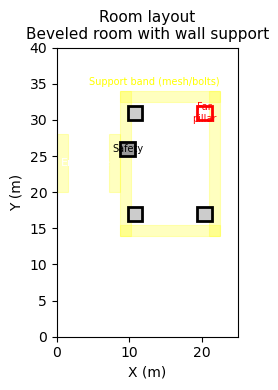

IndexError: list index out of range

In [12]:

#setup_room_rect_unsupported()
setup_room_supported_beveled()

# 2.5) Preview geometry
plot_room_setup()

# 3) Animation (Block 3)
run_pillar_animation()
